# Talking Data

The purpose of this project is to use mobile user data to predict the age group of the user.  The age groups are split betweeen either female or male, then from below 23,to above 43.  Here is what it looks for females: F23-, F24-26, F27-28, F29-32, F33-42, F43+. 

The data is from the Chinese company TalkingData. There are several data sets, each a unique csv: gender_age_train, gender_age_test, events, app_events, app_labels, label_categories and phone_brand_device_model.  

In [43]:
#Importing the packages needed for this analysis
from pygeocoder import Geocoder
import pandas as pd
import io
import numpy as np
import seaborn as sns
from sklearn.metrics import log_loss, roc_auc_score
import pickle
from sklearn.model_selection import train_test_split
import math
import re
import reverse_geocoder as rg
from datetime import *
from scipy import stats
import dateutil.parser
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
from sklearn.model_selection import StratifiedKFold
from IPython.display import display
from sklearn import preprocessing
from googletrans import Translator
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from IPython.core.interactiveshell import InteractiveShell
import goslate
InteractiveShell.ast_node_interactivity = "all"
%matplotlib inline
%config InlineBackend.figure_format = 'png'

plt.rcParams['figure.dpi']= 450

In [2]:
#Connecting to SQL database on an AWS EC2 instance
from sqlalchemy import create_engine
import pandas as pdb
cnx = create_engine('postgresql://djmor@34.234.69.231/djmor')

/anaconda3/lib/python3.6/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


In [3]:
#Loading in coordinates to fast track reverse geocoding
geo = rg.RGeocoder(mode=2, verbose=True, stream=io.StringIO(open('rg_cities1000.csv', encoding='utf-8').read()))

In [4]:
#List of classification types 
classes = {'F23-':0, 'F24-26':1,'F27-28':2,'F29-32':3, 'F33-42':4, 'F43+':5, 'M22-':6, 'M23-26':7, 'M27-28':8, 'M29-31':9, 'M32-38':10, 'M39+':11}
clas = ['F23-', 'F24-26','F27-28','F29-32', 'F33-42', 'F43+', 'M22-', 'M23-26', 'M27-28', 'M29-31', 'M32-38', 'M39+']
           

In [5]:
#Creating all the data frames
device_brand = pd.read_csv('phone_brand_device_model.csv')
applabeldf = pd.read_csv('app_labels.csv')
labelcat = pd.read_csv('label_categories.csv')
genderdf = pd.read_csv('gender_age_train.csv')
eventsdf = pd.read_csv('~/Documents/events.csv')
appevents = pd.read_csv('~/Documents/app_events.csv')
testdf = pd.read_csv('gender_age_test.csv')

In [6]:
testdf.head()
genderdf.head()


,device_id
0,1002079943728939269
1,-1547860181818787117
2,7374582448058474277
3,-6220210354783429585
4,-5893464122623104785


,device_id,gender,age,group
0,-8076087639492063270,M,35,M32-38
1,-2897161552818060146,M,35,M32-38
2,-8260683887967679142,M,35,M32-38
3,-4938849341048082022,M,30,M29-31
4,245133531816851882,M,30,M29-31


In [7]:
device_brand = device_brand.drop_duplicates('device_id',keep='first')
testdf = testdf.drop_duplicates('device_id',keep='first')
genderdf.group = genderdf.group.map(classes)

In [8]:
#Getting an idea on how each df connects with each other
device_brand.head()
appevents.head()
labelcat.head()
eventsdf.head()
applabeldf.head()

,device_id,phone_brand,device_model
0,-8890648629457979026,小米,红米
1,1277779817574759137,小米,MI 2
2,5137427614288105724,三星,Galaxy S4
3,3669464369358936369,SUGAR,时尚手机
4,-5019277647504317457,三星,Galaxy Note 2


,event_id,app_id,is_installed,is_active
0,2,5927333115845830913,1,1
1,2,-5720078949152207372,1,0
2,2,-1633887856876571208,1,0
3,2,-653184325010919369,1,1
4,2,8693964245073640147,1,1


,label_id,category
0,1,NaN
1,2,game-game type
2,3,game-Game themes
3,4,game-Art Style
4,5,game-Leisure time


,event_id,device_id,timestamp,longitude,latitude
0,1,29182687948017175,2016-05-01 00:55:25,121.38,31.24
1,2,-6401643145415154744,2016-05-01 00:54:12,103.65,30.97
2,3,-4833982096941402721,2016-05-01 00:08:05,106.60,29.70
3,4,-6815121365017318426,2016-05-01 00:06:40,104.27,23.28
4,5,-5373797595892518570,2016-05-01 00:07:18,115.88,28.66


,app_id,label_id
0,7324884708820027918,251
1,-4494216993218550286,251
2,6058196446775239644,406
3,6058196446775239644,407
4,8694625920731541625,406


In [9]:
#Translating Phone brand to English for easier comprehension
translate = {'三星':'samsung','天语':'Ktouch','海信':'hisense','联想':'lenovo','欧比':'obi','爱派尔':'ipair','努比亚':'nubia',\
             '优米':'youmi','朵唯':'dowe','黑米':'heymi','锤子':'hammer','酷比魔方':'koobee','美图':'meitu','尼比鲁':'nibilu','一加':'oneplus','优购':'yougo',\
             '诺基亚':'nokia','金立':'jinli','中兴':'zhongxing','糖葫芦':'candy','中国移动':'ccmc','语信':'yuxin','基伍':'kiwu','青橙':'greeno','华硕':'asus',\
             '夏新':'panosonic','维图':'weitu','艾优尼':'aiyouni','摩托罗拉':'moto','乡米':'xiangmi','米奇':'micky','大可乐':'bigcola',\
             '沃普丰':'wpf','神舟':'hasse','摩乐':'mole','酷派':'kupai','飞秒':'fs','米歌':'mige','富可视':'fks','德赛':'desci','梦米':'mengmi','乐视':'lshi','小杨树':'smallt','纽曼':'newman','邦华':'banghua',\
             'E派':'epai','华为':'Huawei','小米':'xiaomi','魅族':'meizu', '易派':'epai','普耐尔':'pner','欧新':'ouxin','西米':'ximi','海尔':'haier','波导':'bodao','糯米':'nuomi','唯米':'weimi','酷珀':'kupo','谷歌':'google','昂达':'ada','聆韵': 'lingyun'}

In [10]:
#Translating phone brand from Chinese to English, can't map because not all models are in chinese(or in translate)
translate_list=[]
for index, i in enumerate(device_brand['phone_brand']):
    if i in translate:
        translate_list.append(translate[i])
    else:
        translate_list.append(i)

In [11]:
len(device_brand.phone_brand)
device_brand['phone_brand']=translate_list


186716

### Data Wrangling

Below is the code for wrangling the data out of eventsdf.  I saved it as a pickle file, so it is no longer needed.

In [ ]:
#Using an offline reverse geocoder to get city and country data, also this takes a long time to run...
counter =0
eventsdf['city'] = ''
tup_ls = []
for i,j in zip(eventsdf['latitude'],eventsdf['longitude']):
        lalong = (i,j)
        tup_ls.append(lalong)




In [ ]:
q_list = geo.query(tup_ls)
name_l = []
cc_l = []
for q in q_list:
    name_l.append(q['name'])
    cc_l.append(q['cc'])

In [ ]:
eventsdf['city'] = name_l
eventsdf['cc'] = cc_l

In [ ]:
#Filling NaN with none for better processing
labelcat.fillna('None', inplace = True)

In [ ]:
#Pulling out Month data
eventsdf['time_dl'] = eventsdf['timestamp'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d  %H:%M:%S').time())
eventsdf['wkday'] = eventsdf['timestamp'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d  %H:%M:%S').weekday())

In [ ]:
#Writing a pickle file to save data

with open('eventsdf.pkl', 'wb') as picklefile:
    pickle.dump(eventsdf, picklefile)

In [ ]:
eventsdf.shape

## Merging the Data

This section may become obsolete after I get the SQL database going, but as for now, it exists.***Delete Eventually***

I will be using Inner joins to merge the data frames.  My guess is that both training and test data is in each of the auxilary columns, so I only want the intersection of the training dataframe and the auxilary dataframes.

In this section, I also added some extra data.  I pulled out the datetime string and converted into into a readable datetime object.  The time of day and day of the week may not make much of a difference.  It depends on the culture of the society.

In [12]:
#Loading DF into jupyter notebook
eventsdf = pd.read_pickle('eventsdf.pkl')
eventsdf = eventsdf[eventsdf['cc'] == "CN"]

In [13]:
def supermerge(dfleft):
    result = pd.merge(dfleft, device_brand, how = 'inner', on = 'device_id')
    print(len(result))
    result = pd.merge(result, eventsdf, how = 'inner', on = 'device_id')
    print(len(result))
    result = pd.merge(result, appevents, how = 'inner', on = 'event_id')
    print(len(result))
    result = pd.merge(result, applabeldf, how = 'inner', on = 'app_id')
    print(len(result))
    result = pd.merge(result, labelcat, how = 'inner', on = 'label_id')
    print(len(result))
    return result

In [14]:
traindf = supermerge(genderdf)

74645
828454
4793232
31292777
31292777


In [15]:
traindf.drop(['gender','age', 'longitude', 'latitude','label_id','event_id', 'time_dl','timestamp','cc', 'is_installed','device_id'], axis=1, inplace = True)
traindf.app_id = traindf.app_id.apply(lambda x: str(x))


In [16]:
traindf.head()

,group,phone_brand,device_model,city,wkday,app_id,is_active,category
0,4,Huawei,荣耀6 plus,Jincheng,2,4307993802327364720,0,Internet Banking
1,4,Huawei,荣耀6 plus,Jincheng,2,4307993802327364720,0,Internet Banking
2,10,Huawei,Ascend P8,Xixing,3,4307993802327364720,0,Internet Banking
3,10,Huawei,Ascend P8,Xixing,5,4307993802327364720,0,Internet Banking
4,10,Huawei,Ascend P8,Hangzhou,2,4307993802327364720,0,Internet Banking


## Preprocessing

The data has many categorical variables that we are using, so a little preprocessing is needed.  I will be using OneHotEncoder to do this for me.

In [17]:
#split X and y into training and testing sets
from sklearn import preprocessing
y = traindf['group']
X= traindf.drop(['group'], axis=1)


In [18]:
def trans(df):
    for column in df.columns:
        if df[column].dtype == type(object):
            le = preprocessing.LabelEncoder()
            df[column] = le.fit_transform(df[column])
    return df

In [19]:
#encoding the values for easy decision tree use
newtraindf = trans(X)

### Undersampling to even out imbalanced classes

The undersampling method of Cluster centroids will be employed to tame the imblanced classes.

In [20]:
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(replacement=True, ratio = 'not minority', random_state=0, return_indices = True)

In [21]:
X_res, y_res, ind= rus.fit_sample(X,y)

[Text(0,0,'F23-'),
 Text(0,0,'F24-26'),
 Text(0,0,'F27-28'),
 Text(0,0,'F29-32'),
 Text(0,0,'F33-42'),
 Text(0,0,'F43+'),
 Text(0,0,'M22-'),
 Text(0,0,'M23-26')]

[[<matplotlib.axis.XTick at 0x1a76849748>,
 (0, 12)]

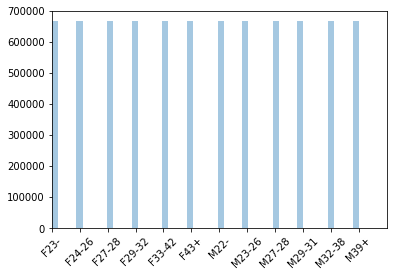

In [22]:
fig = sns.distplot(y_res, kde=False)
fig.set_xticklabels(clas,rotation=45)
fig.set(xlim = (0,12), xticks = range(12))
plt.show()

In [23]:
Xy_df = pd.DataFrame(X_res)

In [24]:
X_train, X_test, y_train, y_test = train_test_split(Xy_df, y_res, test_size=0.3, random_state=30)

In [25]:
(13919+12927)/2

13423.0

In [26]:
#OHE lines, creates a sparse matrix, n_values was found using each sparse matrixs feature length
def OHE(Xy_df):
    enc = preprocessing.OneHotEncoder(n_values=13423)
    newdf = enc.fit_transform(Xy_df)
    return newdf


In [27]:
X_tren = OHE(X_train)
X_teen = OHE(X_test)

In [28]:
X_tren
X_teen

<5602884x93961 sparse matrix of type '<class 'numpy.float64'>'
	with 39220188 stored elements in Compressed Sparse Row format>

<2401236x93961 sparse matrix of type '<class 'numpy.float64'>'
	with 16808652 stored elements in Compressed Sparse Row format>

## Logistic Classification Analysis

The amount of data in the dataframe will make most of the analysis long.  There are 79 million observations, and even splitting it up will make it hard.  Some of the data is in different countries, so dividing it into subsections such as Country, City and Device Brand may make it easier for analysis.  

In [29]:
logit = LogisticRegression()
score=[]

In [30]:
logit.fit(X_tren, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [31]:
logmodel = 'log_model.sav'
pickle.dump(logit, open(logmodel, 'wb'))
#loading pickled model data
logit= pickle.load(open(logmodel, 'rb'))

In [32]:
#loading pickled model data
logit= pickle.load(open(logmodel, 'rb'))

In [33]:
y_pred = logit.predict(X_teen)

In [34]:
f1_score(y_test, y_pred, average='micro')

0.7395203969955473

In [47]:
roc_auc_score(y_test, logit.predict(X_teen))

ValueError: multiclass format is not supported

In [ ]:
# confusion matrix
confusion_matrix(y_test,y_pred)

In [48]:
# Generate a confusion matrix plot: 
from sklearn import cross_validation
def plot_confusion_matrix(cm,title='Confusion matrix', cmap=plt.cm.Reds):
    plt.imshow(cm, interpolation='nearest',cmap=cmap)
    plt.title(title)
    plt.colorbar()
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

#Could be a typical function for classifying:

def train_score(classifier,x,y):
    xtrain, xtest, ytrain, ytest = cross_validation.train_test_split(x, y, test_size=0.2, random_state=1234)
    ytrain=np.ravel(ytrain)
    clf = classifier.fit(xtrain, ytrain)
    # accuracy for test & train:
    train_acc=clf.score(xtrain, ytrain)
    test_acc=clf.score(xtest,ytest)
    print("Training Data Accuracy: %0.2f" %(train_acc))
    print("Test Data Accuracy:     %0.2f" %(test_acc))
    
    y_true = ytest
    y_pred = clf.predict(xtest)


    conf = confusion_matrix(y_true, y_pred)
    print(conf)

    print ('\n')
    print ("Precision:              %0.2f" %(conf[0, 0] / (conf[0, 0] + conf[1, 0])))
    print ("Recall:                 %0.2f"% (conf[0, 0] / (conf[0, 0] + conf[0, 1])))
    
    cm=confusion_matrix(y_true, y_pred, labels=None)
    
    plt.figure()
    plot_confusion_matrix(cm)

/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [ ]:
train_score(logit,X_train,y_train)

## Looking at Trees

Below is looking at the Decision Tree and Random Forests classification methods to see how it differs from the analysis above.



In [ ]:
#split X and y into training and testing sets
X_cat = newtraindf.iloc[ind]
y_cat = traindf.iloc[ind].group
X_tr, X_te, y_tr, y_te = train_test_split(X_cat, y_cat, test_size=0.3, random_state=42)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

In [ ]:
dtree = DecisionTreeClassifier(max_depth=7)
rtree = RandomForestClassifier(max_depth=7)

In [ ]:
dmodel = dtree.fit(X_tr, y_tr)

In [ ]:
#Experiement to see if i should try random forests
from sklearn.model_selection import cross_val_score
cross_val_score(dtree, X_trainc, y_trainc, cv=10)

In [ ]:
y_tree = dmodel.predict(X_te)

In [ ]:
f1_score(y_te, y_tree, average = 'micro')

In [ ]:
# confusion matrix
confusion_matrix(y_te,y_tree)

In [ ]:
rmodel = rtree.fit(X_tr, y_tr)

In [ ]:
y_rtree = rmodel.predict(X_te)
f1_score(y_te, y_rtree, average = 'macro')

In [ ]:
importances = dmodel.feature_importances_
std = np.std([dmodel.feature_importances_ for tree in importances],axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for index,f in enumerate(X_tr.columns):
    print("%d. %s (%f)" % (index+1 , f, importances[indices[index]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_tr.shape[1]), importances[indices],color="r", yerr=std[indices], align="center")
plt.xticks(range(X_tr.shape[1]), X_tr.columns, rotation=45)
plt.xlim([-1, X_tr.shape[1]])
plt.show()

In [ ]:
importances = rmodel.feature_importances_
std = np.std([rmodel.feature_importances_ for tree in importances],axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for index,f in enumerate(X_tr.columns):
    print("%d. %s (%f)" % (index+1 , f, importances[indices[index]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_tr.shape[1]), importances[indices],color="r", yerr=std[indices], align="center")
plt.xticks(range(X_tr.shape[1]), X_tr.columns, rotation=45)
plt.xlim([-1, X_tr.shape[1]])
plt.show()

## Playing with Cats

Trying out catboost for python.  
Before Undersampling feature importance:
* city: 43.66
* device_model: 43.51
* event_id: 12.83

After resampling, while still label encoded, and while not label encoded:
* event_id: 100

After dropping event ID:
* city: 51.67
* device_model: 45.83
* wkday: 2.50

In [ ]:
from catboost import CatBoostRegressor, CatBoostClassifier, Pool
X_cat = traindf.iloc[ind].drop('group', axis=1)
y_cat = traindf.iloc[ind].group
X_trainc, X_testc, y_trainc, y_testc = train_test_split(X_cat, y_cat, test_size=0.3, random_state=42)

In [ ]:
categorical_features_indices = np.where(X_trainc.dtypes != np.float)[0]
train_pool = Pool(X_trainc,y_trainc,cat_features=categorical_features_indices)
validate_pool = Pool(X_testc, y_testc, cat_features=categorical_features_indices)

In [ ]:
#CatBoost
model=CatBoostClassifier(iterations=20, depth=7, learning_rate=0.1, loss_function = 'MultiClass')
model.fit(train_pool, eval_set = (X_testc, y_testc))

In [ ]:
model.save_model('catboost_model.dump')
feature_importances = model.get_feature_importance(train_pool)
feature_names = X_testc.columns
for score, name in sorted(zip(feature_importances, feature_names), reverse=True):
    print('{}: {}'.format(name, score))

In [ ]:
eval_metrics = model.eval_metrics(validate_pool, ['AUC'], plot=True)
print(eval_metrics['AUC'])


In [ ]:
model.save_model('catboost_model.dump')
model.load_model('catboost_model.dump') 

## Naive Bayes

Trying out different models to see which is the best route to analysis. Model ran decently fast and it handled the larger set well.

In [46]:
from sklearn import naive_bayes
from sklearn.metrics import accuracy_score, classification_report

model1 = naive_bayes.BernoulliNB()
model1.fit(X_tren, y_train)

print("Accuracy: %.3f"% f1_score(y_test, model1.predict(X_teen), average = 'macro'))
print(classification_report(y_test, model1.predict(X_teen)))

BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

Accuracy: 0.657
             precision    recall  f1-score   support

          0       0.69      0.74      0.72    200183
          1       0.75      0.74      0.74    200291
          2       0.71      0.68      0.69    200777
          3       0.66      0.66      0.66    200128
          4       0.64      0.66      0.65    199802
          5       0.68      0.74      0.71    200041
          6       0.67      0.67      0.67    199869
          7       0.62      0.58      0.60    199606
          8       0.63      0.64      0.63    200834
          9       0.63      0.57      0.60    199844
         10       0.63      0.59      0.61    199818
         11       0.58      0.61      0.60    200043

avg / total       0.66      0.66      0.66   2401236



## Stochastic Gradient Descent

Trying Stochastic Gradient Descent model to see if I can come up with better numbers.

In [36]:
from sklearn.linear_model import SGDClassifier

In [38]:
sgd = SGDClassifier(loss='log',penalty = 'elasticnet', l1_ratio= .2, max_iter = 500)

In [39]:
sgdmod = sgd.fit(X_tren, y_train)

In [42]:
SGDmodel = 'SGD_model.sav'
pickle.dump(sgdmod, open(SGDmodel, 'wb'))
#loading pickled model data

In [ ]:
sgdmod= pickle.load(open(SGDmodel, 'rb'))

In [40]:
f1_score(y_test, sgdmod.predict(X_teen), average = 'micro') 

0.6103694097539767

In [44]:
roc_auc_score(y_test, sgdmod.predict(X_teen))

ValueError: multiclass format is not supported

## Flask App

Initiating the flask app for D3 visualization.

In [ ]:
from flask import Flask, Response
import json
import urllib2

app = Flask(__name__)

@app.route('/')
def test():
    return 'Everything is running!'

@app.route('/projects/highpoverty/states')
def high_poverty_states():
    donors_choose_url = "http://api.donorschoose.org/common/json_feed.html?highLevelPoverty=true&APIKey=DONORSCHOOSE"
    response = urllib2.urlopen(donors_choose_url)
    json_response = json.load(response)
    states = set()
    for proposal in json_response["proposals"]:
        states.add(proposal["state"])

    return json.dumps(list(states))

In [ ]:
len(traindf.phone_brand.unique())

In [ ]:
traindf[traindf['group'] ==10]
groupnum = []
countnum = []
for i in traindf.group.unique():
    groupnum.append(i)
    for j in traindf.phone_brand.unique():
        